<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Experiments/toy_stationary_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Demonstration of stationary property

In [ ]:
import jax
from jax import random, grad, jit, vmap
from jax.config import config
import jax.numpy as np
from jax.experimental import optimizers, stax

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import os

from tqdm.notebook import tqdm as tqdm

## Random seed
rand_key = random.PRNGKey(10)

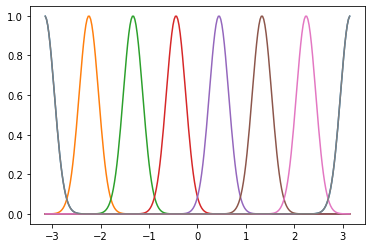

In [ ]:
signal_length = 256
x_min = -np.pi
x_max = np.pi
x_vals = np.linspace(x_min,x_max,signal_length)[...,None]
x_vals_encoded = np.concatenate([np.sin(x_vals), np.cos(x_vals)], axis=-1)

def gen_y_vals(x_vals, center, width):
    return(np.roll(np.exp(-.5 * ((x_vals)/width)**2), int((center/(2*np.pi))*x_vals.shape[0])))
for center in np.linspace(x_min, x_max, 8):
    plt.plot(x_vals, gen_y_vals(x_vals, center, .2))
plt.show()

In [ ]:
def make_network(num_layers, num_channels):
  layers = []
  for i in range(num_layers-1):
      layers.append(stax.Dense(num_channels))
      layers.append(stax.Relu)
  layers.append(stax.Dense(1))
  return stax.serial(*layers)

init_fn, apply_fn = make_network(4, 256)

model_loss = jit(lambda params, x, y: np.mean((apply_fn(params, x) - y) ** 2))
model_grad_loss = jit(lambda params, x, y: jax.grad(model_loss)(params, x, y))

def train_model(key, lr, iters, data):
    opt_init, opt_update, get_params = optimizers.adam(lr)
    opt_update = jit(opt_update)

    _, params = init_fn(key, (-1, data[0].shape[-1]))
    opt_state = opt_init(params)

    losses = []
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *data), opt_state)
        if i % 50 == 0:
            loss = model_loss(get_params(opt_state), *data)
            losses.append(loss)
    return losses

# Ensemble

In [ ]:
ensemble_size = 20
rand_key = random.PRNGKey(10)
ensemble_key = random.split(rand_key, ensemble_size)
lr = 1e-4
iters = 500
no_encoding_losses = []
encoded_losses = []
centers = np.linspace(x_min, x_max, 40)
for center in tqdm(centers, leave=False):
    y_vals = gen_y_vals(x_vals, center, .05)
    no_encoding_losses.append(vmap(train_model, in_axes=[0,None,None,None])(ensemble_key, lr, iters, (x_vals, y_vals))[-1])
    encoded_losses.append(vmap(train_model, in_axes=[0,None,None,None])(ensemble_key, lr, iters, (x_vals_encoded, y_vals))[-1])

no_encoding_losses = np.array(no_encoding_losses)
encoded_losses = np.array(encoded_losses)

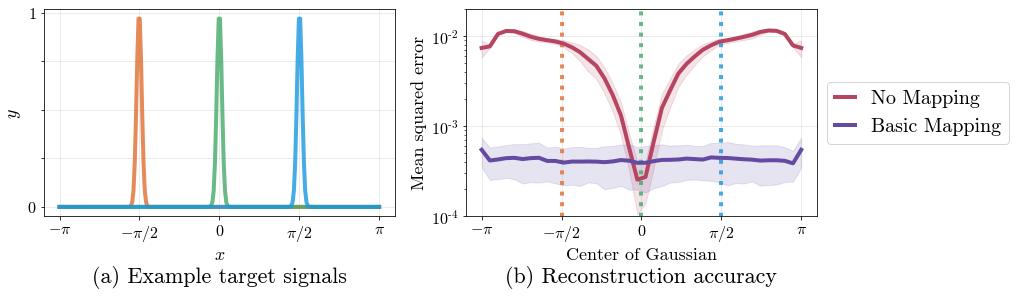

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 20,
         'axes.labelsize': 18,
         'axes.titlesize': 22,
         'xtick.labelsize':16,
         'ytick.labelsize':16}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"


colors_k = np.array([[0.8872, 0.4281, 0.1875],
    # [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])

fig = plt.figure(constrained_layout=True, figsize=(14,4))
gs = fig.add_gridspec(1,2)

centers_to_highlight = [-np.pi/2,0,np.pi/2]
linewidth = 4
title_offset = -.35

ax = fig.add_subplot(gs[0,0])
for i, center in enumerate(centers_to_highlight):
    plt.plot(x_vals, gen_y_vals(x_vals, center, .05), linewidth=linewidth, color=colors_k[i], alpha=.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.yticks([0,.25,.5,.75,1], ['$0$','','','','$1$'])
plt.grid(True, which='major', alpha=.3)
ax.set_title('(a) Example target signals', y=title_offset)

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$'])

ax = fig.add_subplot(gs[0,1])
for i, center in enumerate(centers_to_highlight):
    ax.vlines(center, ymin=0, ymax=70, color=colors_k[i], linestyle=':', linewidth=linewidth, alpha=.8)


no_encoding_mean = np.mean(no_encoding_losses, axis=-1)
no_encoding_std = np.std(no_encoding_losses, axis=-1)
plt.semilogy(centers, no_encoding_mean, color=colors_k[-1], linewidth=linewidth, label='No Mapping')
plt.fill_between(centers, no_encoding_mean-no_encoding_std, no_encoding_mean+no_encoding_std, color=colors_k[-1], alpha=.15)

encoded_mean = np.mean(encoded_losses, axis=-1)
encoded_std = np.std(encoded_losses, axis=-1)
plt.semilogy(centers, encoded_mean, color=colors_k[-2], linewidth=linewidth, label='Basic Mapping')
plt.fill_between(centers, encoded_mean-encoded_std, encoded_mean+encoded_std, color=colors_k[-2], alpha=.15)
plt.xlabel('Center of Gaussian')
plt.ylabel('Mean squared error')
plt.ylim([.0001,.02])
plt.grid(True, which='major', alpha=.3)

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$'])

ax.set_title('(b) Reconstruction accuracy', y=title_offset)
plt.legend(loc='center left', bbox_to_anchor=(1,.5), handlelength=1)

plt.savefig('supp_stationary.pdf', bbox_inches='tight', pad_inches=0)
